In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FORECASTING CON REDES LSTM - PREDICCIONES DE MERCADO

In [ ]:
df = pd.read_csv('../data/indicators_results_10T.csv', sep=';')
df

,datetime,open,close,high,low,up,down,tema_high,tema_low,tema_up,tema_down,macd_line,macd_signal,macd_histogram
0,2022-10-30 19:50:00,4381.25,4377.50,4381.75,4377.00,4.66,9.51,5428.039463,5424.443044,0.785111,3.071348,-128.246801,-25.066078,-103.180722
1,2022-10-30 20:00:00,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
2,2022-10-30 20:10:00,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
3,2022-10-30 20:20:00,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
4,2022-10-30 20:30:00,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112020,2024-12-16 17:50:00,6149.25,6144.50,6150.00,6144.00,10.97,12.44,6152.455837,6146.662142,43.562807,33.122089,0.775892,0.885989,-0.110097
112021,2024-12-16 18:00:00,6149.25,6144.50,6150.00,6144.00,10.97,12.44,6152.455837,6146.662142,43.562807,33.122089,0.775892,0.885989,-0.110097
112022,2024-12-16 18:10:00,6149.25,6144.50,6150.00,6144.00,10.97,12.44,6152.455837,6146.662142,43.562807,33.122089,0.775892,0.885989,-0.110097
112023,2024-12-16 18:20:00,6144.25,6144.00,6146.00,6143.00,6.40,5.75,6148.503043,6142.907183,53.108161,53.572740,0.202393,0.474592,-0.272199


## Eliminar columna datetime

In [13]:
df = df.drop(columns=['datetime'])
df = df.iloc[1:]
df

,open,close,high,low,up,down,tema_high,tema_low,tema_up,tema_down,macd_line,macd_signal,macd_histogram
1,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
2,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
3,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
4,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
5,4371.25,4374.75,4375.75,4370.75,18.59,10.58,4373.471630,4368.308889,16.383236,13.600468,0.259259,0.051852,0.207407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112020,6149.25,6144.50,6150.00,6144.00,10.97,12.44,6152.455837,6146.662142,43.562807,33.122089,0.775892,0.885989,-0.110097
112021,6149.25,6144.50,6150.00,6144.00,10.97,12.44,6152.455837,6146.662142,43.562807,33.122089,0.775892,0.885989,-0.110097
112022,6149.25,6144.50,6150.00,6144.00,10.97,12.44,6152.455837,6146.662142,43.562807,33.122089,0.775892,0.885989,-0.110097
112023,6144.25,6144.00,6146.00,6143.00,6.40,5.75,6148.503043,6142.907183,53.108161,53.572740,0.202393,0.474592,-0.272199


In [14]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (89619, 13)
Tamaño set de validación: (11202, 13)
Tamaño set de prueba: (11203, 13)


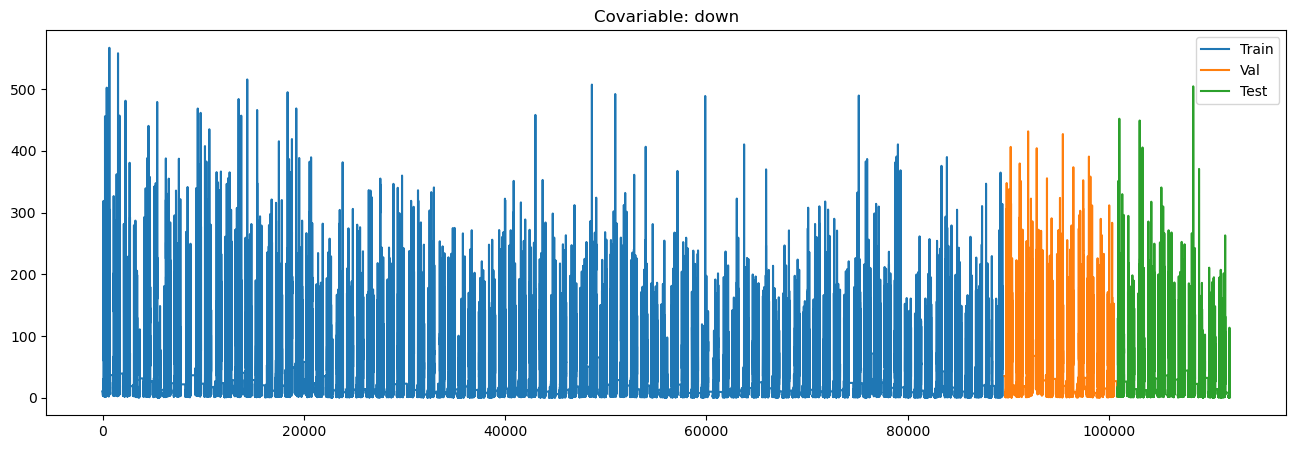

In [15]:
covar = 5 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [16]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 36    # Hiperparámetro
OUTPUT_LENGTH = 6    # Modelo multi-step

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [17]:


x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (89577, 36, 13), y_tr: (89577, 6, 1)
Set de validación - x_vl: (11160, 36, 13), y_vl: (11160, 6, 1)
Set de prueba - x_ts: (11161, 36, 13), y_ts: (11161, 6, 1)


In [18]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [19]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'close')

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

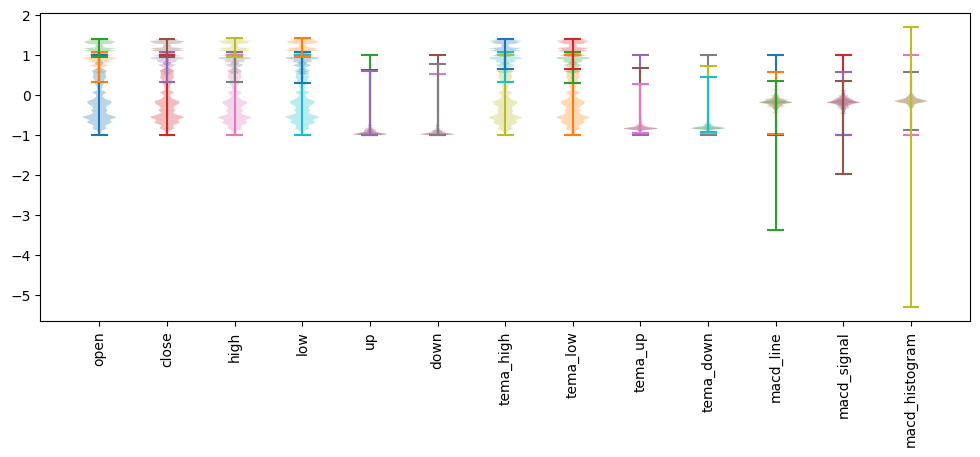

In [ ]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(13):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale()

[Text(1, 0, 'y (salida)')]

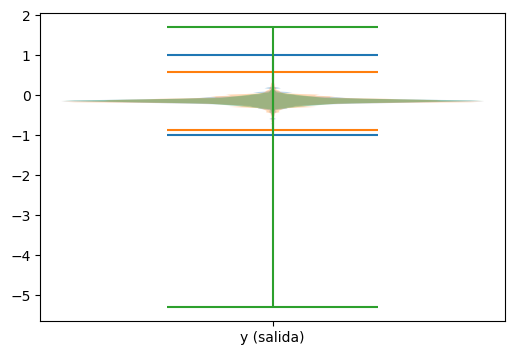

In [20]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)'])

In [ ]:
# Creación del modelo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Configuración para reproducibilidad
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(123)

# Definición del modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        
        # Solo necesitamos la última salida para predecir
        last_output = lstm_out[:, -1, :]
        # Capa de salida para la predicción
        output = self.linear(last_output)
        return output

# Hiperparámetros (manteniendo los mismos que en el código original)
N_UNITS = 128  # Tamaño del estado oculto
EPOCHS = 80
BATCH_SIZE = 256
LEARNING_RATE = 5e-4
OUTPUT_LENGTH = 6  # Asumiendo 4 horas de predicción según el código original

# Convertir datos a tensores de PyTorch
# Asumiendo que x_tr_s, y_tr_s, x_vl_s, y_vl_s ya están definidos como arrays numpy
def numpy_to_torch(x, y):
    x_torch = torch.FloatTensor(x)
    y_torch = torch.FloatTensor(y)
    return x_torch, y_torch
 
# Preparar datos para PyTorch (suponiendo que tenemos x_tr_s, y_tr_s, etc.)
x_train_torch, y_train_torch = numpy_to_torch(x_tr_s, y_tr_s)
x_val_torch, y_val_torch = numpy_to_torch(x_vl_s, y_vl_s)

# Crear DataLoaders
train_dataset = TensorDataset(x_train_torch, y_train_torch)
val_dataset = TensorDataset(x_val_torch, y_val_torch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Inicializar modelo
INPUT_DIM = x_tr_s.shape[2]  # Número de features (13 según el código original)
model = LSTMModel(input_dim=INPUT_DIM, hidden_dim=N_UNITS, output_dim=OUTPUT_LENGTH)

# Función de pérdida personalizada (RMSE)
def root_mean_squared_error(preds, targets):
    return torch.sqrt(torch.mean((preds - targets) ** 2))

# Optimizador (RMSprop para mantener consistencia con el código original)
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {"train_loss": [], "val_loss": []}

for epoch in range(EPOCHS):
    # Modo entrenamiento
    train_losses = []

    model.train()
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward pass
        predictions = model(batch_x)
        loss = root_mean_squared_error(predictions, 6)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Modo evaluación
    model.eval()
    val_losses = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            val_loss = root_mean_squared_error(predictions, 6)
            val_losses.append(val_loss.item())
    
    # Almacenar resultados
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    # Imprimir progreso (similar al verbose=2 en Keras)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

Epoch 1/80 - loss: 0.1542 - val_loss: 0.0468
Epoch 5/80 - loss: 0.0326 - val_loss: 0.0537


KeyboardInterrupt: 

In [ ]:
# Para predecir con el modelo entrenado
def predict(model, x):
    model.eval()
    with torch.no_grad():
        x_torch = torch.FloatTensor(x).to(device)
        predictions = model(x_torch)
        return predictions.cpu().numpy()

In [ ]:
predict(model, x_ts_s)

array([[5.941408 , 5.941424 , 5.9414434, 5.941314 , 5.9414425, 5.9414077],
       [5.941408 , 5.941424 , 5.9414434, 5.941314 , 5.9414425, 5.941407 ],
       [5.941408 , 5.941424 , 5.9414434, 5.941314 , 5.9414425, 5.941407 ],
       ...,
       [5.9414077, 5.9414234, 5.9414425, 5.9413137, 5.941442 , 5.9414067],
       [5.9414077, 5.941423 , 5.9414425, 5.9413137, 5.9414415, 5.9414067],
       [5.9414077, 5.941423 , 5.9414425, 5.9413137, 5.9414415, 5.9414067]],
      dtype=float32)

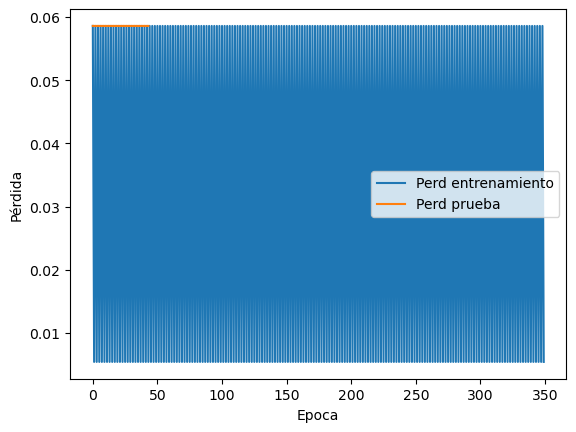

In [ ]:
# Traza las curvas de pérdida
plt.plot(train_losses, label="Perd entrenamiento")
plt.plot(val_losses, label="Perd prueba")
plt.ylabel("Pérdida")
plt.xlabel("Epoca")
plt.legend()

In [ ]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.026
  RMSE val:	 0.051
  RMSE test:	 0.046


ValueError: x and y must be the same size

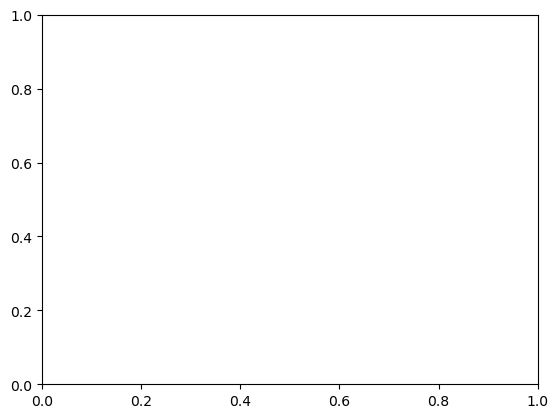

In [ ]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # BATCHESx4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
t = np.linspace(1,4,4)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid()

In [ ]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

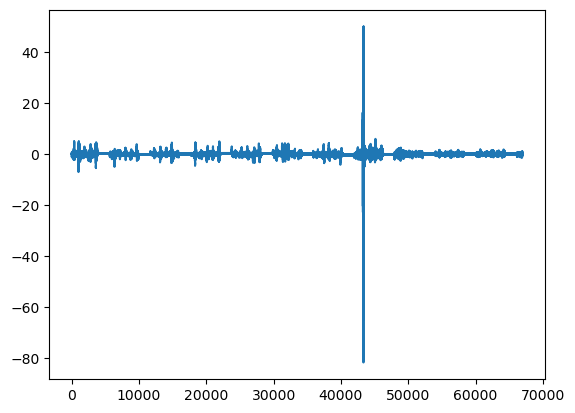

In [ ]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred.flatten()
plt.plot(errores)